In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from MIOFlow.losses import UOT_loss

In [2]:
n1 = 20  # nb samples
n2 = 20  # nb samples
n12 = 20  # nb samples

mu_s = np.array([-1, -1])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([-1, -1])
cov_t = np.array([[1, 0], [0, 1]])

mu_t2 = np.array([-4, 4])
cov_t2 = np.array([[1, 0], [0, 1]])

mu_s2 = np.array([4, 4])
cov_s2 = np.array([[1, 0], [0, 1]])

np.random.seed(0)
xs = ot.datasets.make_2D_samples_gauss(n1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n2, mu_t, cov_t)
xt2 = ot.datasets.make_2D_samples_gauss(n12, mu_t2, cov_t2)
xs2 = ot.datasets.make_2D_samples_gauss(n12, mu_s2, cov_s2)

xs = np.concatenate((xs, xs2), axis=0)
xt = np.concatenate((xt, xt2), axis=0)

n_noise = 0

xs = np.concatenate((xs, ((np.random.rand(n_noise, 2) - 4))), axis=0)
xt = np.concatenate((xt, ((np.random.rand(n_noise, 2) + 6))), axis=0)

xs = torch.tensor(xs, dtype=torch.float32, requires_grad=True)
xt = torch.tensor(xt, dtype=torch.float32, requires_grad=False)

n1 = n1 + n12 + n_noise
# n1 = n1 + n_noise
n2 = n2 + n12 + n_noise

a, b = np.ones((n1,)), np.ones((n2,))  # uniform distribution on samples

a = torch.tensor(a, dtype=torch.float32, requires_grad=True)
b = torch.tensor(b, dtype=torch.float32, requires_grad=True)

# loss matrix
# M = ot.dist(xs, xt)
M = torch.cdist(xs, xt) ** 2
# M /= M.max()



In [3]:
M2 = ot.dist(xs, xt)

In [4]:
torch.isclose(M,M2).all()

tensor(True)

In [5]:
reg = 0.005
reg_m_kl = 0.05
reg_m_l2 = [5, 5]
mass = 0.7

# loss = ot.unbalanced.mm_unbalanced2(a, b, M, reg_m_kl, div='kl')
# loss = ot.emd2(a, b, M)
# loss = ot.sinkhorn2(a, b, M, 0.5, verbose=False)

# Gs = ot.sinkhorn(a, b, M, 0.5, verbose=False)
# loss = ot.unbalanced.sinkhorn_unbalanced2(a, b, M, reg, reg_m_kl)
# Gs = ot.unbalanced.sinkhorn_knopp_unbalanced(a, b, M.detach(), reg, reg_m_kl)
# Gs = ot.partial.partial_wasserstein(a, b, M, m=mass)
# Gs = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_kl, div='kl')
Gs = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_l2, div='l2')
loss1 = (Gs * M).sum()
loss_func = UOT_loss(reg_m_l2=reg_m_l2)
loss, loss_marg = loss_func(xs, xt, a, b)
assert torch.isclose(loss, loss1)
# loss.backward()
loss_marg.backward()
# emd_ot = ot.emd(a, b, M)
# entropic_kl_uot = ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, reg_m_kl)
# kl_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_kl, div='kl')
# l2_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_l2, div='l2')

In [6]:
print(Gs.shape)
print(a.shape, b.shape)
print(Gs.sum(axis=1).shape)

torch.Size([40, 40])
torch.Size([40]) torch.Size([40])
torch.Size([40])


In [7]:
print(a.requires_grad, b.requires_grad)
print(loss.requires_grad)


True True
True


In [8]:
# loss_emd = (emd_ot * M).sum()
# loss_ent_kl = (entropic_kl_uot * M).sum()
# loss_kl_uot = (kl_uot * M).sum()
# loss_l2_uot = (l2_uot * M).sum()

In [9]:
# loss_emd.backward()
# loss_ent_kl.backward()
# loss_kl_uot.backward()

In [10]:
loss

tensor(15.3059, grad_fn=<SumBackward0>)

In [11]:
loss1

tensor(15.3059, grad_fn=<SumBackward0>)

In [12]:
loss_marg

tensor(0.5529, grad_fn=<MseLossBackward0>)

In [13]:
a.grad

tensor([ 0.0230,  0.0319,  0.0162,  0.0080, -0.0032,  0.0064,  0.0076,  0.0038,
         0.0185, -0.0014, -0.0083,  0.0065,  0.0235, -0.0062,  0.0360,  0.0006,
        -0.0153, -0.0077,  0.0234, -0.0105,  0.0500,  0.0500,  0.0500,  0.0500,
         0.0500,  0.0500,  0.0500,  0.0500,  0.0500,  0.0500,  0.0500,  0.0500,
         0.0500,  0.0500,  0.0500,  0.0500,  0.0500,  0.0500,  0.0500,  0.0500])

In [14]:
b.grad

In [15]:
xs.grad

In [16]:
grads0 = a.grad.detach().numpy()

In [17]:
grads0

array([ 0.02302771,  0.03191694,  0.01622397,  0.00800352, -0.00315044,
        0.00637955,  0.00755497,  0.00384114,  0.01854964, -0.00136987,
       -0.00826024,  0.00649847,  0.0235175 , -0.00615786,  0.03600612,
        0.00060824, -0.01529778, -0.00766164,  0.02335169, -0.01053003,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ],
      dtype=float32)

In [18]:
xs.grad

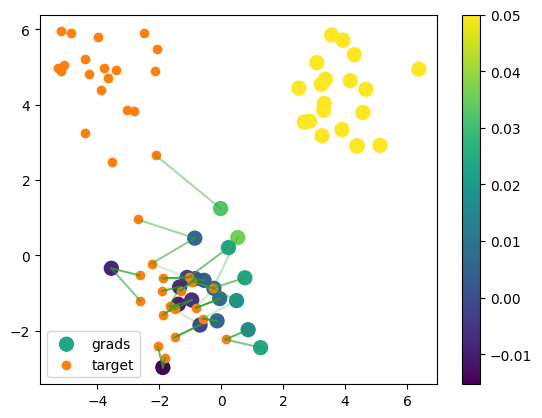

([], [])

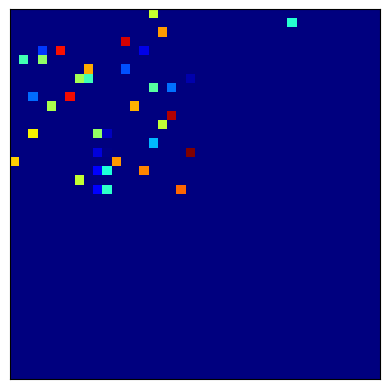

In [19]:
grads = grads0
xs = xs.detach()
xt = xt.detach()
P = Gs.detach().numpy()
if P.sum() > 0:
    P = P / P.max()
for i in range(n1):
    for j in range(n2):
        if P[i, j] > 0:
            pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], color='C2',
                    alpha=P[i, j])
# pl.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=1, label='source')
scatter = pl.scatter(xs[:, 0], xs[:, 1], c=grads, alpha=1, s=100, label='grads')
pl.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=1, label='target')
pl.legend()
pl.colorbar(scatter)
pl.show()
# pl.scatter(xs[:, 0], xs[:, 1], c='C0', s=P.sum(1).ravel() * (1 + p) * 2)
# pl.scatter(xt[:, 0], xt[:, 1], c='C1', s=P.sum(0).ravel() * (1 + p) * 2)
pl.yticks(())
pl.xticks(())
pl.imshow(P, cmap='jet')
pl.yticks(())
pl.xticks(())

In [20]:
P.shape
# show all zero cols and rows of P respectively
zero_cols = np.isclose(P.sum(0), 0)
zero_rows = np.isclose(P.sum(1), 0)

# find the indices of zero cols and rows
zero_cols_indices = np.where(zero_cols)[0]
zero_rows_indices = np.where(zero_rows)[0]
print(zero_cols_indices)
print(zero_rows_indices)


[20 21 22 23 24 25 26 27 28 29 31 32 33 34 35 36 37 38 39]
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


18.625689
18.625687


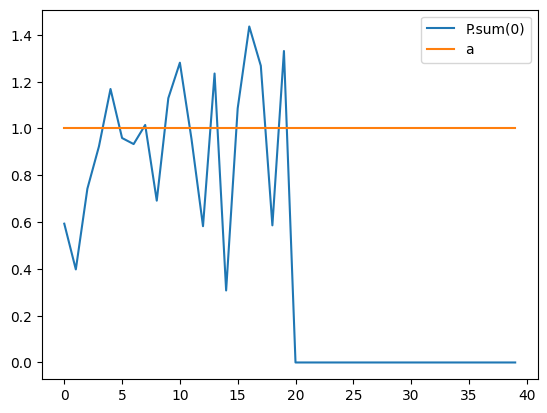

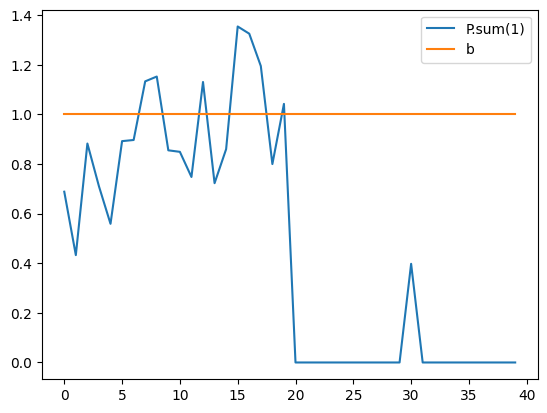

In [21]:
print(P.sum(0).sum())
print(P.sum(1).sum())
# plot P.sum(0) and a in the same plot
pl.plot(P.sum(1), label='P.sum(0)')
pl.plot(a.detach().numpy(), label='a')
pl.legend()
pl.show()
# plot P.sum(1) and b in the same plot
pl.plot(P.sum(0), label='P.sum(1)')
pl.plot(b.detach().numpy(), label='b')
pl.legend()
pl.show()

In [22]:
grads

array([ 0.02302771,  0.03191694,  0.01622397,  0.00800352, -0.00315044,
        0.00637955,  0.00755497,  0.00384114,  0.01854964, -0.00136987,
       -0.00826024,  0.00649847,  0.0235175 , -0.00615786,  0.03600612,
        0.00060824, -0.01529778, -0.00766164,  0.02335169, -0.01053003,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ,
        0.05      ,  0.05      ,  0.05      ,  0.05      ,  0.05      ],
      dtype=float32)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

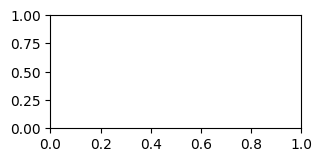

In [23]:

pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gs, 'UOT matrix Sinkhorn')

pl.show()

In [ ]:
pl.figure(4, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.fill(x, Gs.sum(1), 'b', alpha=0.5, label='Transported source')
pl.fill(x, Gs.sum(0), 'r', alpha=0.5, label='Transported target')
pl.legend(loc='upper right')
pl.title('Distributions and transported mass for UOT')

NameError: name 'x' is not defined

<Figure size 640x300 with 0 Axes>